In [2]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

In [3]:
def display_image(image, title):
    plt.figure(figsize=(10, 5))
    plt.imshow(image)
    plt.title(title)
    plt.axis("off")
    plt.show()

def display_gray_image(image, title):
    plt.figure(figsize=(10, 5))
    plt.imshow(image, cmap='gray')
    plt.title(title)
    plt.axis("off")
    plt.show()

In [4]:
image_paths = ['assets/stitching/shanghai-21.png', 'assets/stitching/shanghai-22.png', 'assets/stitching/shanghai-23.png']

gray_imgs_bonus = []
for path in image_paths:
    gray_imgs_bonus.append(cv.imread(path, cv.IMREAD_GRAYSCALE))


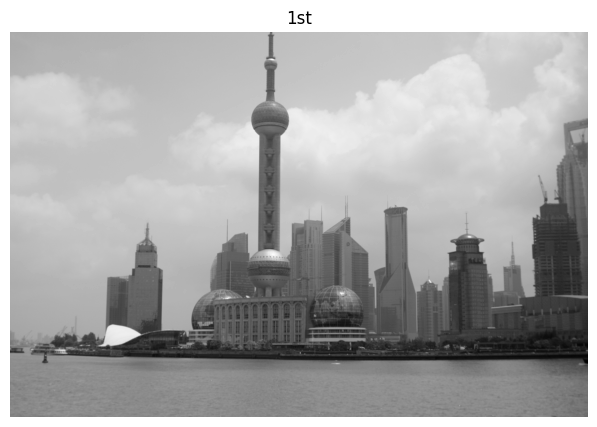

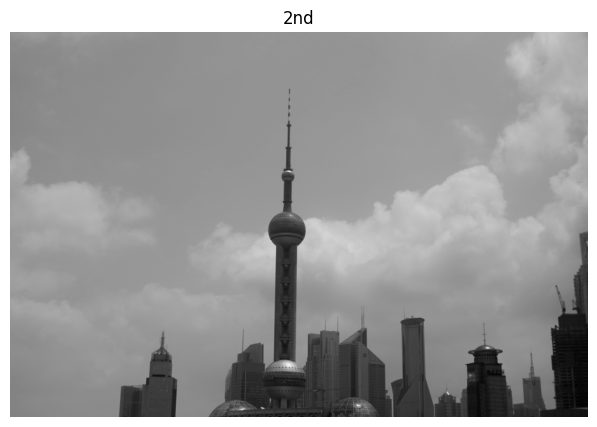

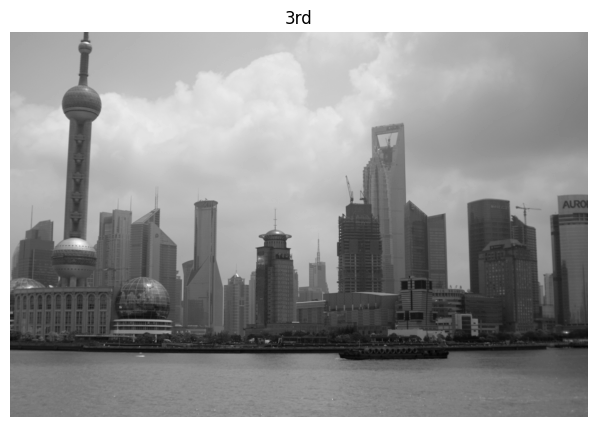

In [5]:
display_gray_image(gray_imgs_bonus[0], "1st")
display_gray_image(gray_imgs_bonus[1], "2nd")
display_gray_image(gray_imgs_bonus[2], "3rd")

In [6]:
sift = cv.SIFT_create()
kp1, des1 = sift.detectAndCompute(gray_imgs_bonus[0], None) #SIFT works best on grayscale images
kp2, des2 = sift.detectAndCompute(gray_imgs_bonus[1], None)
img1 = cv.drawKeypoints(gray_imgs_bonus[0], kp1, gray_imgs_bonus[0].copy(), flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
img2 = cv.drawKeypoints(gray_imgs_bonus[1], kp2, gray_imgs_bonus[1].copy(), flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

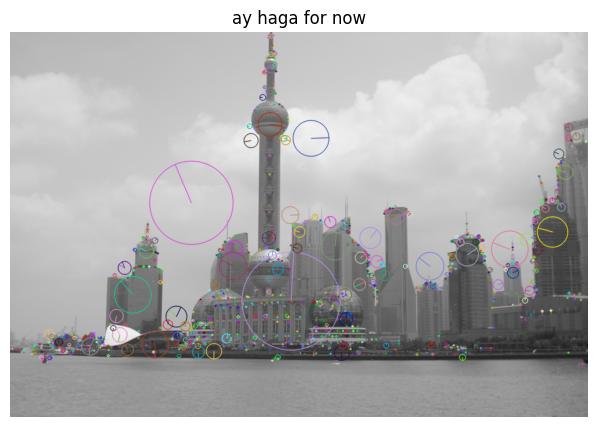

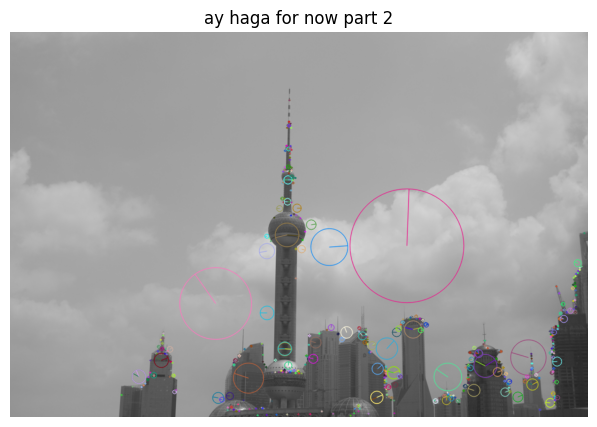

In [7]:
display_image(img1, "ay haga for now")
display_image(img2, "ay haga for now part 2")

In [8]:
bf = cv.BFMatcher()
matches = bf.knnMatch(des1,des2,k=2)

In [9]:
good = []
for m,n in matches:
    if m.distance < 0.5*n.distance:
        good.append([m])

good = sorted(good, key=lambda x: x[0].distance)[:50]

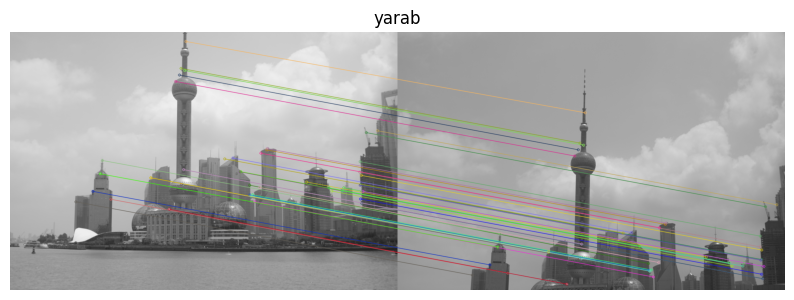

In [10]:
img3 = cv.drawMatchesKnn(gray_imgs_bonus[0],kp1,gray_imgs_bonus[1],kp2,good,None,flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
display_image(img3, "yarab")

In [11]:
def compute_homography_manual(good_matches, kp1, kp2):
    src_pts = np.float32([kp1[m[0].queryIdx].pt for m in good_matches])
    dst_pts = np.float32([kp2[m[0].trainIdx].pt for m in good_matches])

    A = []
    for i in range(len(src_pts)):
        x, y = src_pts[i]
        x_dash, y_dash = dst_pts[i]
        A.append([-x, -y, -1,  0,  0, 0, x * x_dash, y * x_dash, x_dash])
        A.append([ 0,  0, 0, -x, -y, -1, x * y_dash, y * y_dash, y_dash])

    A = np.array(A)

    # Ab = 0 -> SVD stuff
    _, _, Vt = np.linalg.svd(A)
    H = Vt[-1].reshape(3, 3)

    # normalize so  H[2,2] = 1
    H = H / H[2, 2]

    return H, src_pts.reshape(-1, 1, 2), dst_pts.reshape(-1, 1, 2)

In [12]:
H, src_pts, dst_pts = compute_homography_manual(good, kp1, kp2)
print("Manual Homography Matrix:\n", H)


Manual Homography Matrix:
 [[ 9.73190696e-01 -3.82548448e-02  4.04593812e+01]
 [-2.80722083e-03  9.54257311e-01  1.97732691e+02]
 [-1.16974457e-05 -6.23882926e-05  1.00000000e+00]]


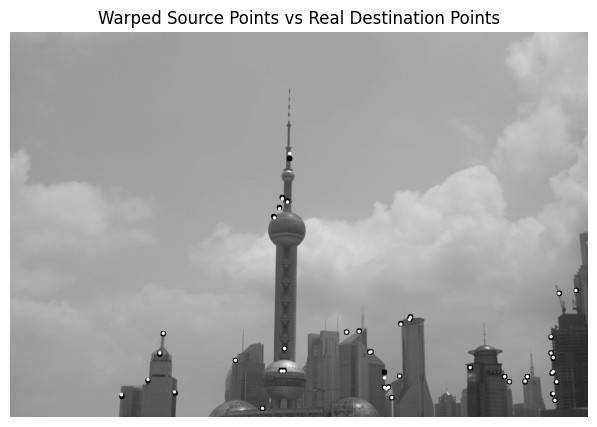

In [13]:
warped_pts = cv.perspectiveTransform(src_pts, H)
img2_verify = gray_imgs_bonus[1].copy()
for pt in warped_pts:
    cv.circle(img2_verify, tuple(np.round(pt[0]).astype(int)), 5, (0, 255, 0), -1)
for pt in dst_pts:
    cv.circle(img2_verify, tuple(np.round(pt[0]).astype(int)), 3, (255, 0, 0), -1)
display_gray_image(img2_verify, "Warped Source Points vs Real Destination Points")


In [14]:
def warp_images(img1, img2, H):
    h1, w1 = img1.shape[:2]
    h2, w2 = img2.shape[:2]
    corners_img1 = np.float32([[0,0],[0,h1],[w1,h1],[w1,0]]).reshape(-1,1,2)
    warped_corners = cv.perspectiveTransform(corners_img1, H)
    corners_img2 = np.float32([[0,0],[0,h2],[w2,h2],[w2,0]]).reshape(-1,1,2)

    all_corners = np.concatenate((warped_corners, corners_img2), axis=0)
    [xmin, ymin] = np.int32(all_corners.min(axis=0).ravel() - 0.5)
    [xmax, ymax] = np.int32(all_corners.max(axis=0).ravel() + 0.5)

    translation = [-xmin, -ymin]
    H_translation = np.array([[1, 0, translation[0]],
                              [0, 1, translation[1]],
                              [0, 0, 1]])

    result = cv.warpPerspective(img1, H_translation.dot(H), (xmax - xmin, ymax - ymin))
    result[translation[1]:translation[1]+h2, translation[0]:translation[0]+w2] = img2

    return result

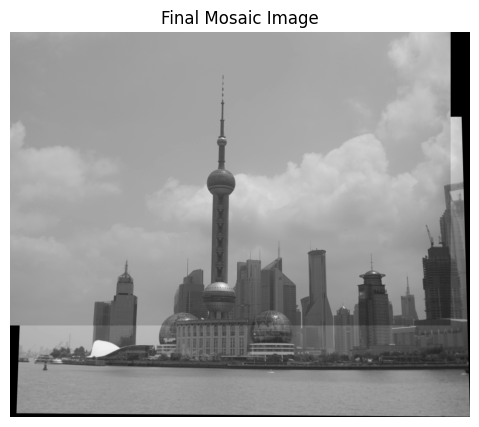

In [15]:
mosaic = warp_images(gray_imgs_bonus[0], gray_imgs_bonus[1], H)
display_gray_image(mosaic, "Final Mosaic Image")

--------------------------------------------------------------------
### **TO BE DONE**

1. Trying different orders
2. removing black spots

- Removing Black Spots

In [16]:
images2 = [mosaic, gray_imgs_bonus[2]]

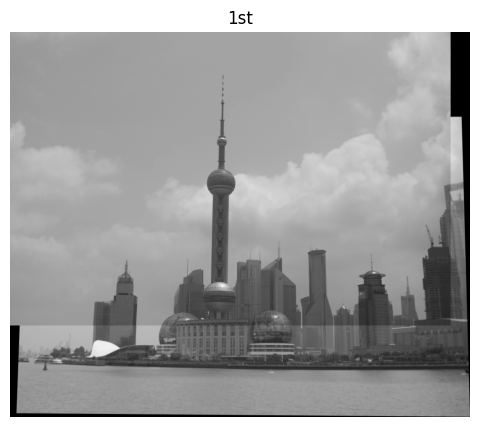

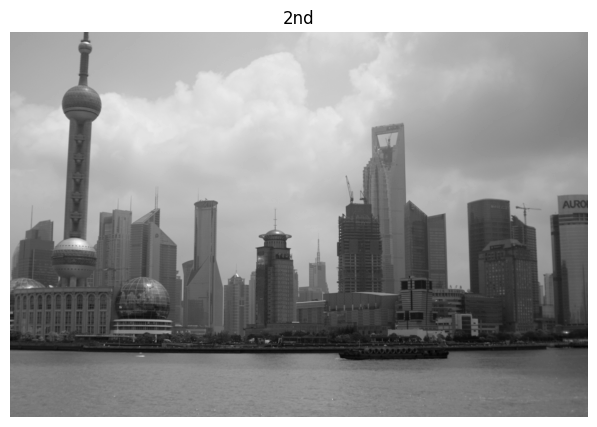

In [17]:
display_gray_image(images2[0], "1st")
display_gray_image(images2[1], "2nd")

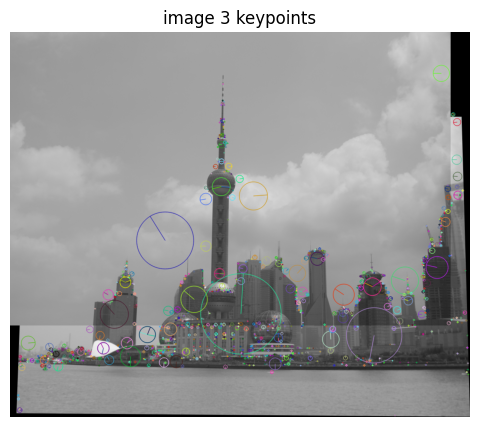

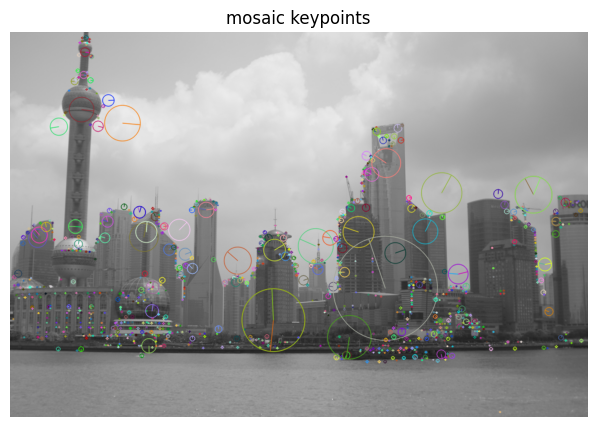

In [18]:
kp21, des21 = sift.detectAndCompute(images2[0], None) 
kp22, des22 = sift.detectAndCompute(images2[1], None)

img21 = cv.drawKeypoints(images2[0], kp21, images2[0].copy(), flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
img22 = cv.drawKeypoints(images2[1], kp22, images2[1].copy(), flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

display_gray_image(cv.drawKeypoints(images2[0], kp21, None, flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS), "image 3 keypoints")
display_gray_image(cv.drawKeypoints(images2[1], kp22, None, flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS), "mosaic keypoints")


In [19]:
bf = cv.BFMatcher()
matches2 = bf.knnMatch(des21,des22,k=2)

In [20]:
good2 = []
for m,n in matches2:
    if m.distance < 0.5*n.distance:
        good2.append([m])

good2 = sorted(good2, key=lambda x: x[0].distance)[:50]

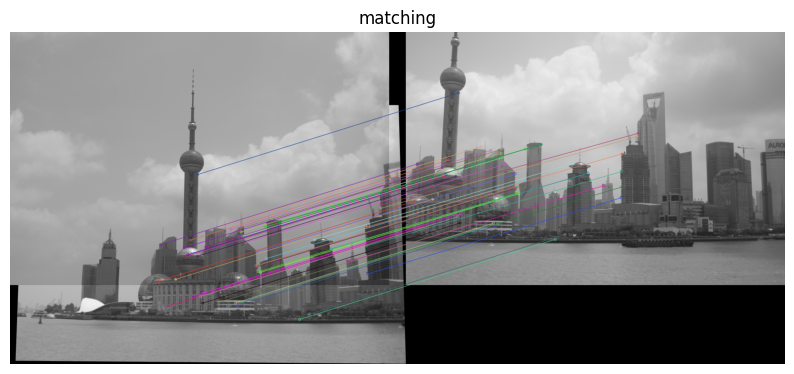

In [21]:
img23 = cv.drawMatchesKnn(images2[0],kp21,images2[1],kp22,good2,None,flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
display_image(img23, "matching")

In [22]:
def get_homography(good, kp1, kp2):
    src_pts = np.float32([kp1[m[0].queryIdx].pt for m in good]).reshape(-1,1,2)
    dst_pts = np.float32([kp2[m[0].trainIdx].pt for m in good]).reshape(-1,1,2)
    H, _ = cv.findHomography(src_pts, dst_pts, cv.RANSAC)
    return H, src_pts, dst_pts

H21, src_pts21, dst_pts21 = get_homography(good2, kp21, kp22)
print("Homography Matrix:\n", H21)

Homography Matrix:
 [[ 1.18235137e+00 -1.85197908e-02 -4.35507287e+02]
 [ 8.90130127e-02  1.16196714e+00 -3.10270621e+02]
 [ 1.44427652e-04  8.45928623e-05  1.00000000e+00]]


In [23]:
H22, src_pts22, dst_pts22 = compute_homography_manual(good2, kp21, kp22)
print("Manual Homography Matrix:\n", H22)


Manual Homography Matrix:
 [[ 1.19082063e+00 -1.74344340e-02 -4.39652081e+02]
 [ 9.11416079e-02  1.17039801e+00 -3.13875050e+02]
 [ 1.48023344e-04  9.19125558e-05  1.00000000e+00]]


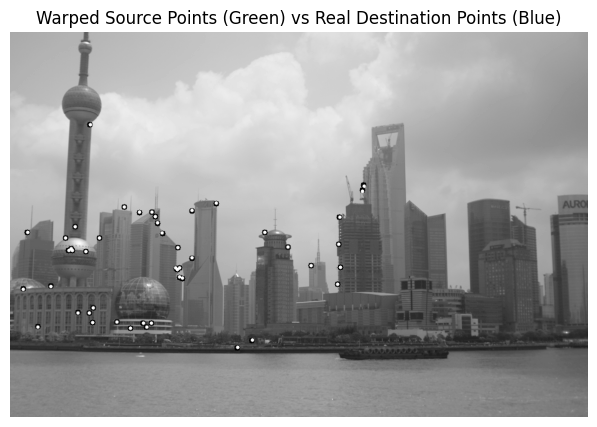

In [24]:
warped_pts = cv.perspectiveTransform(src_pts22, H22)
img2_verify = images2[1].copy()
for pt in warped_pts:
    cv.circle(img2_verify, tuple(np.round(pt[0]).astype(int)), 5, (0, 255, 0), -1)
for pt in dst_pts22:
    cv.circle(img2_verify, tuple(np.round(pt[0]).astype(int)), 3, (255, 0, 0), -1)
display_gray_image(img2_verify, "Warped Source Points (Green) vs Real Destination Points (Blue)")


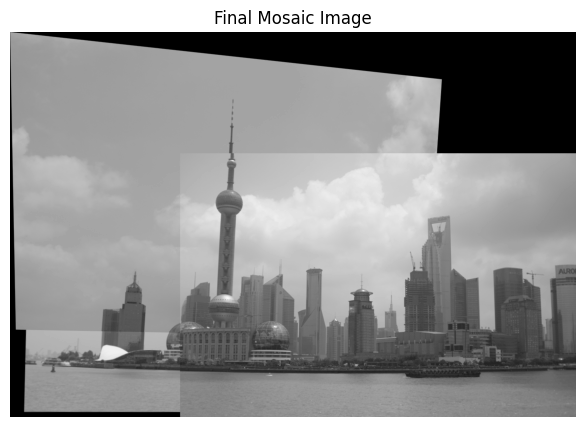

In [ ]:
def warp_images(img1, img2, H):
    h1, w1 = img1.shape[:2]
    h2, w2 = img2.shape[:2]
    corners_img1 = np.float32([[0,0],[0,h1],[w1,h1],[w1,0]]).reshape(-1,1,2)
    warped_corners = cv.perspectiveTransform(corners_img1, H)
    corners_img2 = np.float32([[0,0],[0,h2],[w2,h2],[w2,0]]).reshape(-1,1,2)

    all_corners = np.concatenate((warped_corners, corners_img2), axis=0)
    [xmin, ymin] = np.int32(all_corners.min(axis=0).ravel() - 0.5)
    [xmax, ymax] = np.int32(all_corners.max(axis=0).ravel() + 0.5)

    translation = [-xmin, -ymin]
    H_translation = np.array([[1, 0, translation[0]],
                              [0, 1, translation[1]],
                              [0, 0, 1]])

    result = cv.warpPerspective(img1, H_translation.dot(H), (xmax - xmin, ymax - ymin))
    result[translation[1]:translation[1]+h2, translation[0]:translation[0]+w2] = img2

    return result

mosaic2 = warp_images(images2[0], images2[1], H22)
# mosaic2 = warp_images(mosaic, gray_imgs_bonus[2], H22)
display_gray_image(mosaic2, "Final Mosaic Image")


successful


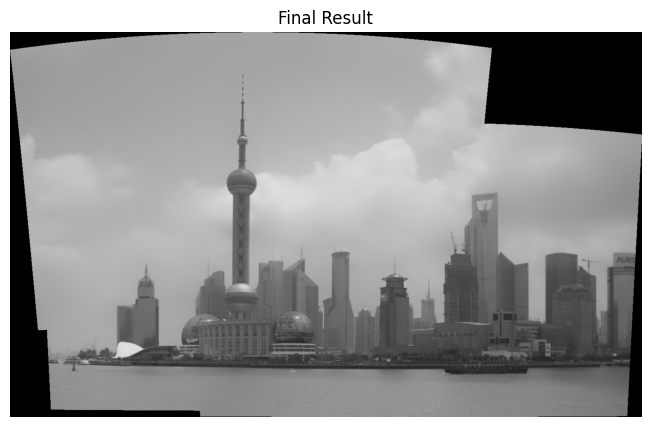

In [29]:
import cv2 
image_paths=['assets/stitching/shanghai-21.png','assets/stitching/shanghai-22.png', 'assets/stitching/shanghai-23.png'] 

imgs = [] 
for i in range(len(image_paths)): 
	imgs.append(cv2.imread(image_paths[i])) 

stitchy=cv2.Stitcher.create() 
(dummy,output)=stitchy.stitch(imgs) 

if dummy != cv2.STITCHER_OK: 
	print("stitching wasn't successful") 
else: 
	print('successful') 
# for i in range(len(image_paths)):
    # display_image(cv2.cvtColor(cv2.imread(image_paths[i]), cv2.COLOR_BGR2RGB), f"Image {i+1}")
display_image(output, "Final Result")



## Questions:
1. How does he builtin stitcher knows the best way/ order of stitching? => literally brute forcing (does not rely on a fixed order)

2. the builtin stitcher: doesnt always use a planar homography (cylindrical/ spherical warping)

3. multiband blending => laplacian pyramids